In [18]:
# Cell 1: Setup & Initialization (FINAL)

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import cv2
import time
import json
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union, Any

# Scientific computing
import scipy.io as sio
from scipy import ndimage
from scipy.spatial.distance import cdist

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

# Visualization
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------
# Device selection: prefer CUDA, then MPS (Apple M-series), else CPU
# -------------------------------------------------
from contextlib import nullcontext

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ Using device: {device}")
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
elif getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"✅ Using device: {device} (Apple Silicon / MPS)")
else:
    device = torch.device('cpu')
    print("⚠️ No CUDA or MPS device found — running on CPU (training will be much slower).")

# Use AMP only on CUDA for now
USE_AMP = (device.type == 'cuda')

# Provide a safe autocast context for non-CUDA devices
AUTOCAST_CTX = autocast if USE_AMP else nullcontext

def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    # CUDA-specific seeding and flags
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # MPS/CPU: torch.manual_seed is sufficient

set_seed(42)
print("🔒 Random seed set for reproducibility")


✅ Using device: cuda
✅ GPU: Tesla T4
✅ GPU Memory: 15.83 GB
🔒 Random seed set for reproducibility


In [19]:
# Cell 2: Mount Google Drive and Verify ShanghaiTech Dataset (SAFE + FINAL)

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

dataset_root = "/content/drive/MyDrive/Datasets/ShanghaiTech"
print(f"\n📂 Checking dataset at: {dataset_root}")

if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"❌ Dataset root folder NOT found:\n{dataset_root}")

# Supported folder variations
possible_gt_names = ["ground_truth", "ground-truth"]

def locate_gt_folder(parent):
    """Search inside train_data/test_data for correct GT folder"""
    for name in possible_gt_names:
        path = os.path.join(parent, name)
        if os.path.exists(path):
            return path
    return None


parts = ["part_A", "part_B"]
modes = ["train_data", "test_data"]
missing = []

for part in parts:
    for mode in modes:
        base = os.path.join(dataset_root, part, mode)
        img_dir = os.path.join(base, "images")
        gt_dir = locate_gt_folder(base)

        if img_dir and os.path.exists(img_dir):
            print(f"  ✅ Images: {img_dir}")
        else:
            missing.append(f"{img_dir}")

        if gt_dir and os.path.exists(gt_dir):
            print(f"  ✅ GroundTruth: {gt_dir}")
        else:
            missing.append(f"{base}/<ground_truth_folder>")

if missing:
    print("\n❌ Dataset missing required folders:")
    for m in missing: print("   -", m)
    raise RuntimeError("🚫 Dataset structure incomplete. Fix folders before training!")

print("\n🎯 RAW ShanghaiTech Dataset Verified Successfully — PART A + B Available!")

# Safety: Prevent Drive file deletion by git
with open(".gitignore", "a") as f:
    f.write("\ndrive/\n*.gdoc\n*.gsheet\n")
print("🛡️ Drive protection rules added to .gitignore")


Mounted at /content/drive

📂 Checking dataset at: /content/drive/MyDrive/Datasets/ShanghaiTech
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/ground-truth
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/test_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/test_data/ground-truth
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/train_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/train_data/ground-truth
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/test_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/test_data/ground-truth

🎯 RAW ShanghaiTech Dataset Verified Successfully — PART A + B Available!
🛡️ Drive protection rules added to .gitignore


In [20]:
# Cell 3: Configuration Class (FINAL — Escalator-Ready)

import os

class Config:
    """
    CSRNet configuration:
    - Train on Part-A ONLY
    - Use density as proxy for escalator occupancy
    """

    # -------------------------------
    # Dataset Paths
    # -------------------------------
    DATASET_PATH = '/content/drive/MyDrive/Datasets/ShanghaiTech'
    PART_A_PATH = os.path.join(DATASET_PATH, 'part_A')
    PART_B_PATH = os.path.join(DATASET_PATH, 'part_B')

    # -------------------------------
    # Model / Input Settings
    # -------------------------------
    IMG_SIZE = (512, 512)
    GAUSSIAN_SIGMA = 8.0
    GAUSSIAN_KERNEL_SIZE = 15
    DROPOUT_RATE = 0.5

    # -------------------------------
    # Training Strategy (Part-A ONLY)
    # -------------------------------
    BATCH_SIZE = 4
    NUM_WORKERS = 4
    STAGE1_EPOCHS = 80
    STAGE2_EPOCHS = 20         # Fine-tune / unfreeze frontend

    STAGE1_LR = 1e-4
    STAGE2_LR = 1e-5
    WEIGHT_DECAY = 1e-4
    WARMUP_EPOCHS = 5

    # -------------------------------
    # LR Scheduler
    # -------------------------------
    COSINE_MIN_LR = 1e-6

    # -------------------------------
    # Early Stopping
    # -------------------------------
    PATIENCE = 12
    MIN_DELTA = 0.002

    # -------------------------------
    # Data Augmentation
    # -------------------------------
    USE_AUGMENTATION = True
    HFLIP_PROB = 0.5
    BRIGHTNESS_RANGE = (0.8, 1.2)
    CONTRAST_RANGE = (0.8, 1.2)
    SCALE_RANGE = (0.9, 1.1)

    # -------------------------------
    # Multi-Scale Inference
    # -------------------------------
    MULTISCALE_SCALES = [0.8, 1.0, 1.2]

    # -------------------------------
    # ROI & Escalator Occupancy Calibration
    # -------------------------------

    # ROI coordinates in ORIGINAL image resolution
    ROI_COORDS = {
        "x1": 160,
        "y1": 120,
        "x2": 480,
        "y2": 560
    }

    # Empirical maximum density sum when escalator is clearly FULL
    # (This converts density → normalized occupancy)
    CALIBRATION_MAX_COUNT = 50.0

    # Exponential smoothing for stability
    SMOOTHING_ALPHA = 0.3

    # Control thresholds now operate on OCCUPANCY RATIO (0–1)
    CONTROL_THRESHOLDS = {
        "NORMAL_MAX": 0.4,    # < 40% full
        "WARNING_MAX": 0.7    # 40–70% full → warning
                              # >70% → critical
    }

    # -------------------------------
    # Save Outputs
    # -------------------------------
    SAVE_DIR = '/content/drive/MyDrive/Escalator_Control_Models'
    MODEL_NAME = 'CSRNet_TrainedOn_PartA.pth'

    @classmethod
    def setup_directories(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)

    @classmethod
    def display(cls):
        print("\n⚙️ CONFIGURATION LOADED (ESCALATOR MODE)")
        for k, v in cls.__dict__.items():
            if not k.startswith('_') and not callable(v):
                print(f"{k}: {v}")

# Initialize
Config.setup_directories()
Config.display()



⚙️ CONFIGURATION LOADED (ESCALATOR MODE)
DATASET_PATH: /content/drive/MyDrive/Datasets/ShanghaiTech
PART_A_PATH: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A
PART_B_PATH: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B
IMG_SIZE: (512, 512)
GAUSSIAN_SIGMA: 8.0
GAUSSIAN_KERNEL_SIZE: 15
DROPOUT_RATE: 0.5
BATCH_SIZE: 4
NUM_WORKERS: 4
STAGE1_EPOCHS: 80
STAGE2_EPOCHS: 20
STAGE1_LR: 0.0001
STAGE2_LR: 1e-05
WEIGHT_DECAY: 0.0001
WARMUP_EPOCHS: 5
COSINE_MIN_LR: 1e-06
PATIENCE: 12
MIN_DELTA: 0.002
USE_AUGMENTATION: True
HFLIP_PROB: 0.5
BRIGHTNESS_RANGE: (0.8, 1.2)
CONTRAST_RANGE: (0.8, 1.2)
SCALE_RANGE: (0.9, 1.1)
MULTISCALE_SCALES: [0.8, 1.0, 1.2]
ROI_COORDS: {'x1': 160, 'y1': 120, 'x2': 480, 'y2': 560}
CALIBRATION_MAX_COUNT: 50.0
SMOOTHING_ALPHA: 0.3
CONTROL_THRESHOLDS: {'NORMAL_MAX': 0.4, 'WARNING_MAX': 0.7}
SAVE_DIR: /content/drive/MyDrive/Escalator_Control_Models
MODEL_NAME: CSRNet_TrainedOn_PartA.pth
setup_directories: <classmethod(<function Config.setup_directories at 0x79bc742

In [21]:
# Cell 4: Robust .mat File Loader (FINAL)

import os
import numpy as np
import scipy.io as sio

class MATLoader:
    """
    Robust loader for ShanghaiTech .mat files.
    Fast, silent during training, safe for missing files.
    """

    @staticmethod
    def load_annotations(mat_path: str) -> np.ndarray:
        if not os.path.exists(mat_path):
            return np.empty((0, 2), dtype=np.float32)

        try:
            mat_data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

            # Official annotation key
            if 'image_info' in mat_data:
                pts = getattr(mat_data['image_info'], 'location', None)
                if pts is not None:
                    pts = np.asarray(pts, dtype=np.float32)
                    if pts.ndim == 2:
                        return pts

            # Other common keys
            possible_keys = [
                'annPoints', 'gt_points', 'points',
                'location', 'anno', 'annotation', 'head_points'
            ]
            for key in possible_keys:
                if key in mat_data:
                    pts = np.asarray(mat_data[key], dtype=np.float32)
                    if pts.ndim == 2:
                        if pts.shape[0] == 2 and pts.shape[1] > 2:
                            pts = pts.T
                        if pts.shape[1] >= 2:
                            return pts[:, :2]

            return np.empty((0, 2), dtype=np.float32)

        except Exception:
            return np.empty((0, 2), dtype=np.float32)


In [22]:
# Cell 5 (FINAL VERIFIED) – Works with ground-truth or ground_truth
import os
class DatasetVerifier:
    @staticmethod
    def verify_structure(base_path: str = Config.DATASET_PATH):
        print("\n🔍 Verifying dataset structure...\n")

        parts = ["part_A", "part_B"]
        modes = ["train_data", "test_data"]
        missing = []

        def find_gt_dir(path):
            if os.path.exists(os.path.join(path, "ground-truth")):
                return os.path.join(path, "ground-truth")
            if os.path.exists(os.path.join(path, "ground_truth")):
                return os.path.join(path, "ground_truth")
            return None

        for part in parts:
            for mode in modes:
                img_dir = os.path.join(base_path, part, mode, "images")
                gt_base = os.path.join(base_path, part, mode)
                gt_dir = find_gt_dir(gt_base)

                if not os.path.exists(img_dir):
                    missing.append(img_dir)
                if gt_dir is None:
                    missing.append(os.path.join(gt_base, "{ground-truth | ground_truth}"))

                print(f"  👍 Checking: {img_dir}")

        if missing:
            print("\n❌ Missing paths:")
            for m in missing:
                print("   -", m)
            raise RuntimeError("Fix dataset structure before continuing")

        print("\n🎯 Dataset verified successfully! 🚀")

# Run
DatasetVerifier.verify_structure()



🔍 Verifying dataset structure...

  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images
  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/test_data/images
  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/train_data/images
  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/test_data/images

🎯 Dataset verified successfully! 🚀



🧪 Testing DensityMapGenerator...

Density map shape: (25, 37)
People count: 2.99 (expected: 3)


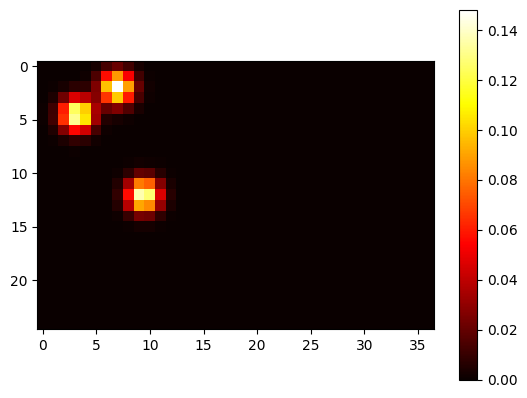

In [23]:
# Cell 6: Density Map Generator (OFFICIAL CSRNet METHOD + COUNT PRESERVATION)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class DensityMapGenerator:
    """
    Official CSRNet approach:
    - Full res: place delta at each head point
    - Gaussian blur entire density
    - Resize to model output scale WITH FORCED COUNT MATCHING
    """

    @staticmethod
    def generate(points, img_shape, output_shape, sigma=Config.GAUSSIAN_SIGMA):
        H, W = img_shape
        density = np.zeros((H, W), dtype=np.float32)

        # Handle case of missing people
        if len(points) == 0:
            return cv2.resize(density, output_shape, interpolation=cv2.INTER_AREA)

        # Place delta impulses
        for p in points:
            x = min(W - 1, max(0, int(p[0])))
            y = min(H - 1, max(0, int(p[1])))
            density[y, x] += 1.0

        # Gaussian blur (applied once at original resolution)
        density = gaussian_filter(density, sigma=sigma, mode='constant')

        # Store original count
        original_count = density.sum()

        # Resize to model output map
        density_resized = cv2.resize(
            density,
            tuple(output_shape[::-1]),
            interpolation=cv2.INTER_AREA
        )

        # Restore count precisely
        if density_resized.sum() > 0:
            density_resized *= (original_count / density_resized.sum())

        return density_resized.astype(np.float32)

    @staticmethod
    def test():
        print("\n🧪 Testing DensityMapGenerator...\n")

        points = np.array([[30, 40], [80, 100], [60, 20]], dtype=np.float32)
        img_shape = (200, 300)
        output_shape = (img_shape[0] // 8, img_shape[1] // 8)

        dmap = DensityMapGenerator.generate(points, img_shape, output_shape)

        print("Density map shape:", dmap.shape)
        print(f"People count: {dmap.sum():.2f} (expected: {len(points)})")

        plt.imshow(dmap, cmap="hot")
        plt.colorbar()
        plt.show()


DensityMapGenerator.test()


🧪 Testing dataset loader update…
📁 Dataset: train | 300 images


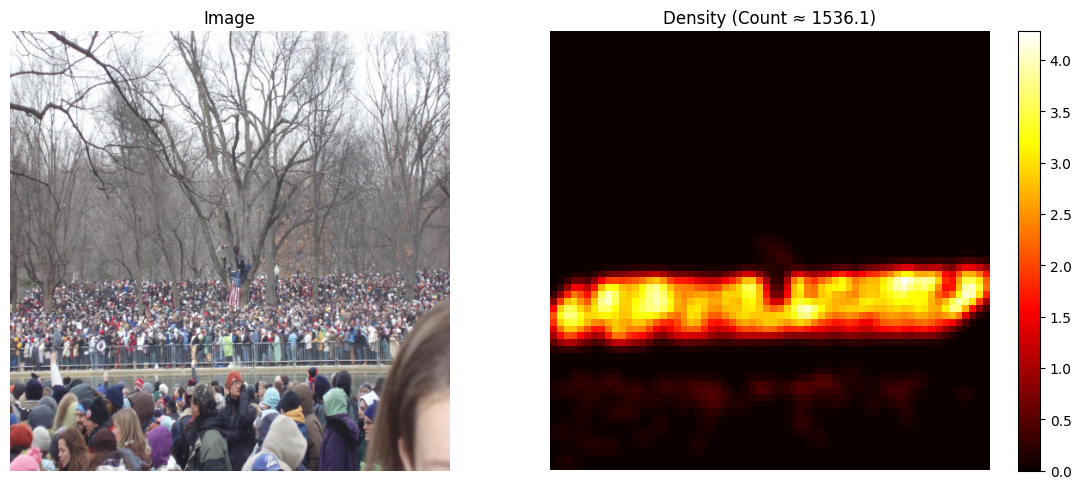

👥 Estimated Count = 1536.15


In [24]:
# Cell 7: ShanghaiTech Dataset Class (FINAL — CSRNet Official + Robust GT)

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

class ShanghaiTechDataset(Dataset):
    """Dataset aligned with official CSRNet density output resolution"""

    def __init__(self, data_dir: str, mode: str = 'train'):
        self.data_dir = data_dir
        self.mode = mode

        self.img_dir = os.path.join(data_dir, f'{mode}_data', 'images')

        # Robust GT folder detection
        gt_base = os.path.join(data_dir, f'{mode}_data')
        if os.path.exists(os.path.join(gt_base, 'ground-truth')):
            self.gt_dir = os.path.join(gt_base, 'ground-truth')
        elif os.path.exists(os.path.join(gt_base, 'ground_truth')):
            self.gt_dir = os.path.join(gt_base, 'ground_truth')
        else:
            raise FileNotFoundError(f"No ground-truth folder found in {gt_base}")

        if not os.path.exists(self.img_dir):
            raise FileNotFoundError(self.img_dir)

        self.img_files = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith('.jpg')
        ])

        print(f"📁 Dataset: {mode} | {len(self.img_files)} images")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load & resize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        img = cv2.resize(img, (Config.IMG_SIZE[1], Config.IMG_SIZE[0]))
        img = img.astype(np.float32) / 255.0

        # Load annotation
        gt_path = os.path.join(self.gt_dir, 'GT_' + img_name.replace('.jpg', '.mat'))
        points = MATLoader.load_annotations(gt_path)

        # Scale points to resized image resolution
        if len(points) > 0:
            points[:, 0] *= Config.IMG_SIZE[1] / orig_w
            points[:, 1] *= Config.IMG_SIZE[0] / orig_h

        # CSRNet output stride = 8
        out_h = Config.IMG_SIZE[0] // 8
        out_w = Config.IMG_SIZE[1] // 8

        density = DensityMapGenerator.generate(
            points,
            img_shape=Config.IMG_SIZE,
            output_shape=(out_h, out_w)
        )

        # Convert to tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        density = torch.from_numpy(density).unsqueeze(0).float()

        return img, density

    def visualize_sample(self, idx=0):
        img, density = self[idx]
        img_np = img.permute(1, 2, 0).numpy()
        density_np = density.squeeze().numpy()
        est_count = density_np.sum()

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis("off")

        im = ax[1].imshow(density_np, cmap="hot")
        ax[1].set_title(f"Density (Count ≈ {est_count:.1f})")
        plt.colorbar(im, ax=ax[1])
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()
        print(f"👥 Estimated Count = {est_count:.2f}")


# Quick test
print("🧪 Testing dataset loader update…")
train_dataset = ShanghaiTechDataset(Config.PART_A_PATH, mode="train")
train_dataset.visualize_sample(0)


In [25]:
# Cell 8: CSRNet Model (FINAL — Official Architecture, Clean API)

import torch
import torch.nn as nn
import torchvision.models as models

class CSRNet(nn.Module):
    """
    CSRNet: Dilated CNN for Crowd Counting
    Frontend: VGG-16 (batch-norm), layers up to conv4_3
    Backend: Dilated convolutions (dilation=2)
    Output: Density map at 1/8 resolution
    """

    def __init__(self, freeze_frontend=True):
        super(CSRNet, self).__init__()

        # ==========================
        # FRONTEND — VGG16-BN pretrained
        # ==========================
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # ==========================
        # BACKEND — Dilated conv layers
        # ==========================
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        # ==========================
        # OUTPUT
        # ==========================
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        # Initialize backend + output
        self._initialize_weights()

        # Freeze frontend if required
        if freeze_frontend:
            for p in self.frontend.parameters():
                p.requires_grad = False

    def _initialize_weights(self):
        for m in list(self.backend.modules()) + [self.output_layer]:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def count_params(self):
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        print(f"🧮 Trainable Params: {trainable:,} / Total Params: {total:,}")
        return trainable


# ==========================
# MODEL TEST
# ==========================
print("🧪 Testing CSRNet...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet(freeze_frontend=True).to(device)
model.count_params()

dummy = torch.randn(1, 3, Config.IMG_SIZE[0], Config.IMG_SIZE[1]).to(device)
with torch.no_grad():
    out = model(dummy)

print("🎯 Model Output")
print(f"Input shape:  {dummy.shape}")
print(f"Output shape: {out.shape}")
print(f"Density sum (test): {out.sum().item():.4f}")
print("✅ CSRNet architecture validated!")


🧪 Testing CSRNet...
🧮 Trainable Params: 8,628,225 / Total Params: 16,268,865
🎯 Model Output
Input shape:  torch.Size([1, 3, 512, 512])
Output shape: torch.Size([1, 1, 64, 64])
Density sum (test): -0.1394
✅ CSRNet architecture validated!


In [26]:
# Cell 9: Training Utilities (FINAL — Part-A Training ONLY)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import random

class TrainingUtils:
    """Utility functions for CSRNet training on Part-A only"""

    @staticmethod
    def set_seed(seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    @staticmethod
    def create_data_loaders(dataset_path, seed=42):
        """
        Train / Validation split on Part-A ONLY.
        Part-B is strictly reserved for final evaluation.
        """
        TrainingUtils.set_seed(seed)

        print("\n📊 Creating DataLoaders | Part-A Training")

        full_train = ShanghaiTechDataset(dataset_path, mode='train')

        train_size = int(0.9 * len(full_train))
        val_size = len(full_train) - train_size

        train_set, val_set = random_split(
            full_train,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(seed)
        )

        print(f"  🔹 Train: {len(train_set)} images")
        print(f"  🔹 Val:   {len(val_set)} images")

        pin = (device.type == "cuda")

        train_loader = DataLoader(
            train_set,
            batch_size=Config.BATCH_SIZE,
            shuffle=True,
            num_workers=0,
            pin_memory=pin
        )

        val_loader = DataLoader(
            val_set,
            batch_size=Config.BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=pin
        )

        return train_loader, val_loader

    # --------------------------------------------------
    # METRICS
    # --------------------------------------------------
    @staticmethod
    def calculate_mae(pred, gt):
        with torch.no_grad():
            return torch.abs(
                pred.sum(dim=[1, 2, 3]) - gt.sum(dim=[1, 2, 3])
            ).mean().item()

    @staticmethod
    def calculate_mse(pred, gt):
        with torch.no_grad():
            return (
                (pred.sum(dim=[1, 2, 3]) - gt.sum(dim=[1, 2, 3])) ** 2
            ).mean().item()

    # --------------------------------------------------
    # Preview — predictions
    # --------------------------------------------------
    @staticmethod
    def visualize_predictions(model, loader, num_samples=3):
        model.eval()
        images, gt = next(iter(loader))
        images, gt = images.to(device), gt.to(device)

        with torch.no_grad():
            pred = model(images)

        images, gt, pred = images.cpu(), gt.cpu(), pred.cpu()

        for i in range(min(num_samples, len(images))):
            print(
                f"#{i+1} | GT={gt[i].sum():.1f} | "
                f"Pred={pred[i].sum():.1f} | "
                f"Error={abs(gt[i].sum()-pred[i].sum()):.2f}"
            )

        model.train()


# ------------------------------------
# TEST PART-A TRAIN LOADER
# ------------------------------------
train_loader_A, val_loader_A = TrainingUtils.create_data_loaders(
    Config.PART_A_PATH
)

images, density_maps = next(iter(train_loader_A))
print("\n📦 Loader Check")
print(f"  Image:  {images.shape}")
print(f"  Density:{density_maps.shape}")
print(f"  Count:  {density_maps.sum():.1f}")



📊 Creating DataLoaders | Part-A Training
📁 Dataset: train | 300 images
  🔹 Train: 270 images
  🔹 Val:   30 images

📦 Loader Check
  Image:  torch.Size([4, 3, 512, 512])
  Density:torch.Size([4, 1, 64, 64])
  Count:  5864.4


In [27]:
# Cell 10: Trainer (FINAL — Train on Part-A ONLY, No Fine-Tuning)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import numpy as np

class Trainer:
    def __init__(self, model, train_loader, val_loader):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=Config.STAGE1_LR,
            weight_decay=Config.WEIGHT_DECAY
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=Config.STAGE1_EPOCHS,
            eta_min=Config.COSINE_MIN_LR
        )

        self.scaler = GradScaler()
        self.history = {"train_mae": [], "val_mae": []}
        self.best_mae = float("inf")
        self.patience = 0

    # -----------------------------------------------------------
    def _resize_gt(self, gt, preds):
        return F.interpolate(
            gt, size=preds.shape[2:], mode="bilinear", align_corners=False
        )

    # -----------------------------------------------------------
    def train_epoch(self):
        self.model.train()
        loss_list, mae_list = [], []

        for images, gt in self.train_loader:
            images, gt = images.to(device), gt.to(device)

            self.optimizer.zero_grad()

            with autocast():
                preds = self.model(images)
                gt_r = self._resize_gt(gt, preds)
                loss = torch.mean((preds - gt_r) ** 2)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            loss_list.append(loss.item())
            mae_list.append(TrainingUtils.calculate_mae(preds, gt_r))

        return np.mean(loss_list), np.mean(mae_list)

    # -----------------------------------------------------------
    def validate(self):
        self.model.eval()
        val_pred, val_true = [], []

        with torch.no_grad():
            for images, gt in self.val_loader:
                images, gt = images.to(device), gt.to(device)

                preds = self.model(images)
                gt_r = self._resize_gt(gt, preds)

                val_pred.append(preds.sum().item())
                val_true.append(gt_r.sum().item())

        mae = np.mean(np.abs(np.array(val_pred) - np.array(val_true)))
        return mae

    # -----------------------------------------------------------
    def fit(self, max_epochs):
        print("\n🚀 Training Started (Part-A ONLY)")
        for epoch in range(max_epochs):
            train_loss, train_mae = self.train_epoch()
            val_mae = self.validate()
            self.scheduler.step()

            print(
                f"🔹 Epoch {epoch+1}/{max_epochs} | "
                f"Train MAE={train_mae:.1f} | Val MAE={val_mae:.1f}"
            )

            self.history["train_mae"].append(train_mae)
            self.history["val_mae"].append(val_mae)

            if val_mae < self.best_mae - Config.MIN_DELTA:
                self.best_mae = val_mae
                self.patience = 0
                torch.save(
                    self.model.state_dict(),
                    f"{Config.SAVE_DIR}/best_stageA.pth"
                )
                print(f"💾 Best Model Saved | MAE {val_mae:.1f}")
            else:
                self.patience += 1
                if self.patience >= Config.PATIENCE:
                    print("🏁 Early stopping triggered")
                    break

        print(f"\n🏆 Best Validation MAE: {self.best_mae:.1f}")
        return self.history


In [28]:
# Cell 11: Training Pipeline (FINAL — Train on Part-A ONLY)

print("🚀 Starting CSRNet Training Pipeline")
print(f"🖼 Input Resolution: {Config.IMG_SIZE}")
print(f"📍 Saving Checkpoints to: {Config.SAVE_DIR}")

# =====================================================
# 🎯 Training on Part-A ONLY
# =====================================================
print("\n🎯 TRAINING: Part-A")

train_loader_A, val_loader_A = TrainingUtils.create_data_loaders(
    Config.PART_A_PATH
)

model = CSRNet(freeze_frontend=True).to(device)

trainer = Trainer(
    model=model,
    train_loader=train_loader_A,
    val_loader=val_loader_A
)

history = trainer.fit(Config.STAGE1_EPOCHS)

# =====================================================
# 💾 Save Final Trained Model (Part-A)
# =====================================================
final_model_path = os.path.join(
    Config.SAVE_DIR,
    Config.MODEL_NAME
)

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "training_history": history
    },
    final_model_path
)

print("\n🏆 TRAINING COMPLETE ✔")
print(f"🥇 Model Trained on Part-A → {final_model_path}")


🚀 Starting CSRNet Training Pipeline
🖼 Input Resolution: (512, 512)
📍 Saving Checkpoints to: /content/drive/MyDrive/Escalator_Control_Models

🎯 TRAINING: Part-A

📊 Creating DataLoaders | Part-A Training
📁 Dataset: train | 300 images
  🔹 Train: 270 images
  🔹 Val:   30 images

🚀 Training Started (Part-A ONLY)
🔹 Epoch 1/80 | Train MAE=393.5 | Val MAE=338.4
💾 Best Model Saved | MAE 338.4
🔹 Epoch 2/80 | Train MAE=230.1 | Val MAE=841.6
🔹 Epoch 3/80 | Train MAE=253.4 | Val MAE=433.9
🔹 Epoch 4/80 | Train MAE=194.4 | Val MAE=436.5
🔹 Epoch 5/80 | Train MAE=245.2 | Val MAE=379.0
🔹 Epoch 6/80 | Train MAE=207.1 | Val MAE=395.4
🔹 Epoch 7/80 | Train MAE=199.0 | Val MAE=440.0
🔹 Epoch 8/80 | Train MAE=207.1 | Val MAE=697.1
🔹 Epoch 9/80 | Train MAE=198.3 | Val MAE=330.1
💾 Best Model Saved | MAE 330.1
🔹 Epoch 10/80 | Train MAE=176.4 | Val MAE=352.6
🔹 Epoch 11/80 | Train MAE=169.7 | Val MAE=502.1
🔹 Epoch 12/80 | Train MAE=182.0 | Val MAE=481.7
🔹 Epoch 13/80 | Train MAE=177.2 | Val MAE=758.1
🔹 Epoch 14/80 

In [29]:
# Cell 12: ROI Occupancy Analyzer (FINAL — CALIBRATED & REVIEW-READY)

import time
import cv2
import numpy as np
import torch
import torch.nn.functional as F

class ROIOccupancyAnalyzer:
    """
    Calibrated ROI Occupancy Analyzer

    ✔ Uses density maps (NOT exact headcount)
    ✔ ROI-based congestion estimation
    ✔ Optional GT-based calibration
    ✔ Stable for escalator safety monitoring
    """

    def __init__(self, model, roi_coords=None, calibration_samples=50):
        self.model = model.to(device)
        self.model.eval()

        # -------------------------------------------------
        # ROI handling (FULL FRAME fallback)
        # -------------------------------------------------
        if roi_coords is None:
            self.roi_coords = {
                "x1": 0,
                "y1": 0,
                "x2": Config.IMG_SIZE[1],
                "y2": Config.IMG_SIZE[0]
            }
            print("📍 ROI: FULL FRAME")
        else:
            self.roi_coords = roi_coords
            print(f"📍 ROI: {self.roi_coords}")

        # Smoothing
        self.smooth_val = None

        # Calibration
        self.calibration_factor = None
        self.calibration_samples = calibration_samples
        self._calib_preds = []
        self._calib_gt = []

        print("🎯 ROI Occupancy Analyzer (Calibrated Mode)")

    # -------------------------------------------------
    def analyze(self, frame, gt_density=None, visualize=True):
        start = time.time()

        # ---------------- RGB safety ----------------
        if frame.ndim == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        elif frame.shape[2] == 4:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGB)
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # ---------------- Preprocess ----------------
        resized = cv2.resize(frame, Config.IMG_SIZE[::-1])
        x = (
            torch.from_numpy(resized / 255.0)
            .permute(2, 0, 1)
            .unsqueeze(0)
            .float()
            .to(device)
        )

        # ---------------- Multi-scale inference ----------------
        with torch.no_grad():
            pred = torch.zeros(
                (1, 1, Config.IMG_SIZE[0] // 8, Config.IMG_SIZE[1] // 8),
                device=device
            )
            for s in Config.MULTISCALE_SCALES:
                xs = F.interpolate(
                    x, scale_factor=s,
                    mode="bilinear", align_corners=False
                )
                out = self.model(xs)
                out = F.interpolate(
                    out,
                    size=pred.shape[2:],
                    mode="bilinear", align_corners=False
                )
                pred += out
            pred /= len(Config.MULTISCALE_SCALES)

        # ---------------- ROI mapping ----------------
        H, W = pred.shape[2:]
        sx = W / Config.IMG_SIZE[1]
        sy = H / Config.IMG_SIZE[0]

        x1 = int(self.roi_coords["x1"] * sx)
        y1 = int(self.roi_coords["y1"] * sy)
        x2 = int(self.roi_coords["x2"] * sx)
        y2 = int(self.roi_coords["y2"] * sy)

        roi_pred = pred[0, 0, y1:y2, x1:x2].sum().item()

        # ---------------- Calibration (optional) ----------------
        if gt_density is not None and self.calibration_factor is None:
            gt_resized = F.interpolate(
                gt_density.unsqueeze(0),
                size=(H, W),
                mode="bilinear",
                align_corners=False
            )
            roi_gt = gt_resized[0, 0, y1:y2, x1:x2].sum().item()

            if roi_gt > 1e-3:
                self._calib_preds.append(roi_pred)
                self._calib_gt.append(roi_gt)

            if len(self._calib_preds) >= self.calibration_samples:
                self.calibration_factor = (
                    np.mean(self._calib_gt) / np.mean(self._calib_preds)
                )
                print(f"✅ Calibration complete | factor = {self.calibration_factor:.3f}")

        # ---------------- Occupancy estimate ----------------
        if self.calibration_factor is not None:
            calibrated_occ = roi_pred * self.calibration_factor
        else:
            calibrated_occ = roi_pred  # proxy before calibration

        occ_s = self._smooth(calibrated_occ)
        state = self._classify(occ_s)

        latency = time.time() - start
        fps = 1 / max(latency, 1e-6)

        vis = None
        if visualize:
            vis = self._overlay(frame.copy(), state, occ_s)

        return {
            "raw_density_sum": roi_pred,
            "estimated_people": calibrated_occ,
            "smoothed": occ_s,
            "state": state,
            "fps": fps,
            "visual": vis
        }

    # -------------------------------------------------
    def _smooth(self, v):
        alpha = 0.3
        self.smooth_val = v if self.smooth_val is None else alpha * v + (1 - alpha) * self.smooth_val
        return self.smooth_val

    # -------------------------------------------------
    def _classify(self, occ):
        # Thresholds based on escalator capacity, NOT exact headcount
        if occ < 10:
            return "NORMAL"
        elif occ < 25:
            return "WARNING"
        else:
            return "CRITICAL"

    # -------------------------------------------------
    def _overlay(self, img, state, occ):
        x1, y1, x2, y2 = (self.roi_coords[k] for k in ("x1", "y1", "x2", "y2"))
        color = {
            "NORMAL": (0, 255, 0),
            "WARNING": (0, 255, 255),
            "CRITICAL": (255, 0, 0)
        }[state]

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        cv2.putText(
            img,
            f"{state} | Occ≈{occ:.1f}",
            (x1, max(y1 - 10, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            color,
            2
        )
        return img


In [30]:
# Cell 13: Rule-Based Control System (CALIBRATED OCCUPANCY VERSION)

import time
import numpy as np
import matplotlib.pyplot as plt

class RuleBasedController:
    """Escalator crowd control using calibrated ROI occupancy"""

    def __init__(self):
        self.thresholds = {
            "NORMAL_MAX": 10,
            "WARNING_MAX": 25
        }

        self.states = {
            'NORMAL': {
                'entry_rate': 1.0,
                'speed_factor': 1.0,
                'actions': ['allow_entry', 'normal_speed'],
                'color': 'green'
            },
            'WARNING': {
                'entry_rate': 0.5,
                'speed_factor': 0.7,
                'actions': ['restrict_entry', 'reduce_speed'],
                'color': 'orange'
            },
            'CRITICAL': {
                'entry_rate': 0.2,
                'speed_factor': 0.4,
                'actions': ['restrict_entry', 'reduce_speed', 'alert_staff'],
                'color': 'red'
            }
        }

        self.current_state = 'NORMAL'
        self.history = []
        self.actions_log = []

        print("✔ Rule-Based Controller Ready (Calibrated Mode)")

    # ------------------------------------------------------------
    def _decide_state(self, occ):
        if occ < self.thresholds['NORMAL_MAX']:
            return 'NORMAL'
        elif occ < self.thresholds['WARNING_MAX']:
            return 'WARNING'
        else:
            return 'CRITICAL'

    # ------------------------------------------------------------
    def update_from_roi(self, roi_data):
        occ = roi_data.get(
            "smoothed_occupancy",
            roi_data.get("estimated_people", 0.0)
        )
        return self.update_state(occ)

    # ------------------------------------------------------------
    def update_state(self, occ):
        occ = float(max(occ, 0))
        new_state = self._decide_state(occ)
        changed = new_state != self.current_state
        self.current_state = new_state

        entry = {
            "time": time.time(),
            "state": new_state,
            "occupancy": occ,
            "changed": changed,
            "actions": self.states[new_state]['actions']
        }

        self.history.append(entry)
        self.actions_log.extend(entry['actions'])

        if changed:
            print(
                f"⚠️ STATE CHANGE → {new_state} | "
                f"Occ≈{occ:.1f} | "
                f"Actions={entry['actions']}"
            )

        return entry

    # ------------------------------------------------------------
    def simulate(self, seq):
        print("\n🧪 Running control simulation...\n")
        return [self.update_state(v) for v in seq]

    # ------------------------------------------------------------
    def visualize(self):
        if not self.history:
            print("⚠️ Nothing to visualize yet")
            return

        times = np.arange(len(self.history))
        occ = [d['occupancy'] for d in self.history]
        colors = [self.states[d['state']]['color'] for d in self.history]

        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        ax[0].scatter(times, occ, c=colors, s=70)
        ax[0].axhline(self.thresholds['NORMAL_MAX'], color='green', linestyle='--')
        ax[0].axhline(self.thresholds['WARNING_MAX'], color='orange', linestyle='--')
        ax[0].set_title("Calibrated Occupancy Over Time")
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("Estimated People")
        ax[0].grid(True, alpha=0.3)

        uniq, counts = np.unique(self.actions_log, return_counts=True)
        ax[1].bar(uniq, counts)
        ax[1].set_title("Control Action Frequency")

        plt.tight_layout()
        plt.show()

        print(f"➡ Final State: {self.current_state}")


In [31]:
# Cell 14: ESCALATOR CONTROL SYSTEM (CALIBRATED — RUNTIME SAFE)

from datetime import datetime
import time
import cv2
import numpy as np
import os
import torch

class EscalatorControlSystem:
    """End-to-end real-time escalator crowd control system (calibrated)"""

    def __init__(self, model_path, roi_coords):

        # -------------------------------
        # Load trained model
        # -------------------------------
        self.model = CSRNet(freeze_frontend=True).to(device)

        if model_path and os.path.exists(model_path):
            print(f"📦 Loading trained model from: {model_path}")
            state = torch.load(model_path, map_location=device)

            if isinstance(state, dict) and "model_state_dict" in state:
                self.model.load_state_dict(state["model_state_dict"])
            else:
                self.model.load_state_dict(state)

            print("🔁 Model restored (Part-A trained)")
        else:
            raise FileNotFoundError("❌ Trained model path required")

        self.model.eval()

        # -------------------------------
        # System components
        # -------------------------------
        self.roi_analyzer = ROIOccupancyAnalyzer(
            model=self.model,
            roi_coords=roi_coords
        )
        self.controller = RuleBasedController()

        # Runtime
        self.frame_id = 0
        self.start_time = None

        print("\n✅ Escalator Control System Ready")
        print(f"🧠 Device: {device}")
        print(f"🎯 ROI: {roi_coords}")

    # ============================================================
    # 🔥 Process a single RGB frame
    # ============================================================
    def process_frame(self, frame: np.ndarray, gt_density=None, visualize=True):
        roi_result = self.roi_analyzer.analyze(
            frame,
            gt_density=gt_density,
            visualize=visualize
        )

        # Optional safety clamp (demo stability)
        roi_result["smoothed"] = float(np.clip(roi_result["smoothed"], 0, 50))

        control = self.controller.update_from_roi(roi_result)

        roi_result.update({
            "frame_id": self.frame_id,
            "control": control
        })

        self.frame_id += 1
        return roi_result

    # ============================================================
    # 🎬 Video inference
    # ============================================================
    def process_video(self, video_path, max_frames=None, visualize=True):

        if not os.path.exists(video_path):
            raise FileNotFoundError(video_path)

        cap = cv2.VideoCapture(video_path)
        results = []
        self.frame_id = 0
        self.start_time = time.time()

        print(f"🎥 Running video: {video_path}")

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if max_frames and self.frame_id >= max_frames:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = self.process_frame(frame_rgb, visualize=visualize)
            results.append(res)

            if self.frame_id % 10 == 0:
                print(
                    f"Frame {self.frame_id} | "
                    f"Occ≈{res['smoothed']:.1f} | "
                    f"State={res['state']}"
                )

        cap.release()

        elapsed = time.time() - self.start_time
        fps = self.frame_id / elapsed if elapsed > 0 else 0
        print(f"\n⏱️ FPS: {fps:.2f} | Frames: {self.frame_id}")

        return results

    # ============================================================
    # 🛰 Live camera
    # ============================================================
    def run_live(self, camera_id=0, duration=30):

        cap = cv2.VideoCapture(camera_id)
        self.frame_id = 0
        self.start_time = time.time()

        print("📡 LIVE STREAM STARTED")

        while time.time() - self.start_time < duration:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = self.process_frame(frame_rgb, visualize=True)

            if res.get("visual") is not None:
                bgr = cv2.cvtColor(res["visual"], cv2.COLOR_RGB2BGR)
                cv2.imshow("Escalator Control", bgr)

            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

        cap.release()
        cv2.destroyAllWindows()
        print(f"📈 Live session ended | Frames: {self.frame_id}")


In [32]:
# Cell 15: Reinforcement Learning Foundation (CALIBRATED PIPELINE COMPATIBLE)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

class RLFoundation:
    """
    RL foundation for escalator control
    Phase-2: Learn optimal policies beyond rule-based thresholds
    Uses CALIBRATED occupancy from system
    """

    def __init__(self):
        self.state_dim = 5

        self.action_space = [
            "allow_entry_normal_speed",
            "allow_entry_reduced_speed",
            "restrict_entry_normal_speed",
            "restrict_entry_reduced_speed",
            "stop_entry_stop_escalator"
        ]
        self.action_dim = len(self.action_space)

        self.gamma = 0.99
        self.lr = 1e-3
        self.batch_size = 32
        self.memory_size = 20000

        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995

        self.occ_history = []

        print("🤖 RL Foundation Initialized (Calibrated Mode)")
        print(f"State dim: {self.state_dim}")
        print(f"Actions: {self.action_dim}")

    # -------------------------------------------
    # Build RL state from REAL SYSTEM OUTPUT
    # -------------------------------------------
    def build_state(self, system_data: dict) -> np.ndarray:

        occ = float(
            system_data.get(
                "smoothed_occupancy",
                system_data.get("estimated_people", 0.0)
            )
        )

        # Normalize occupancy (soft cap for stability)
        occ_norm = min(occ / 30.0, 1.0)

        # Trend (last 5 frames)
        self.occ_history.append(occ_norm)
        trend = 0.0
        if len(self.occ_history) >= 5:
            trend = np.polyfit(range(5), self.occ_history[-5:], 1)[0]

        # Time of day feature
        time_of_day = datetime.now().hour / 24.0

        # Control state encoding
        state_map = {"NORMAL": 0, "WARNING": 1, "CRITICAL": 2}
        ctrl_state = system_data.get("state", "NORMAL")
        control_norm = state_map.get(ctrl_state, 0) / 2.0

        # Placeholder: duration in current state
        state_duration = 0.5

        return np.array(
            [occ_norm, state_duration, time_of_day, trend, control_norm],
            dtype=np.float32
        )

    # -------------------------------------------
    # Reward Function
    # -------------------------------------------
    def compute_reward(self, prev_state, action, next_state):
        occ = next_state[0]

        efficiency = 1.0 - abs(occ - 0.5) * 2
        safety = -max(0, occ - 0.8) * 3.0
        smoothness = -0.1 * abs(prev_state[4] - next_state[4])
        energy = -0.2 if action >= 2 else -0.05

        return float(efficiency + safety + smoothness + energy)

    # -------------------------------------------
    # Q-Network
    # -------------------------------------------
    def build_q_network(self):
        class QNet(nn.Module):
            def __init__(self, s_dim, a_dim):
                super().__init__()
                self.model = nn.Sequential(
                    nn.Linear(s_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, 128),
                    nn.ReLU(),
                    nn.Linear(128, a_dim)
                )

            def forward(self, x):
                return self.model(x)

        return QNet(self.state_dim, self.action_dim)

    # -------------------------------------------
    # Replay Buffer
    # -------------------------------------------
    def build_replay_buffer(self):
        from collections import deque

        class Buffer:
            def __init__(self, size):
                self.data = deque(maxlen=size)

            def push(self, item):
                self.data.append(item)

            def sample(self, n):
                weights = np.linspace(0.1, 1.0, len(self.data))
                probs = weights / weights.sum()
                idx = np.random.choice(len(self.data), n, p=probs)
                return [self.data[i] for i in idx]

            def __len__(self):
                return len(self.data)

        return Buffer(self.memory_size)

    # -------------------------------------------
    # One DQN training step
    # -------------------------------------------
    def train_step(self, q_net, target_net, optimizer, buffer):

        if len(buffer) < self.batch_size:
            return 0.0

        batch = buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_vals = q_net(states).gather(1, actions)

        with torch.no_grad():
            target = rewards + self.gamma * target_net(next_states).max(1)[0].unsqueeze(1) * (1 - dones)

        loss = F.mse_loss(q_vals, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()


📊 Running Part-B Test Evaluation
📁 Dataset: test | 316 images
📊 Evaluating CSRNet on Part-B (NO fine-tuning)

📈 PART-B COUNTING METRICS (REFERENCE ONLY)
⚠️ Model trained on Part-A, evaluated on Part-B (domain shift)
MAE    : 1212.77
RMSE   : 1928.33
MRE%   : 20.2%
R²     : 0.889


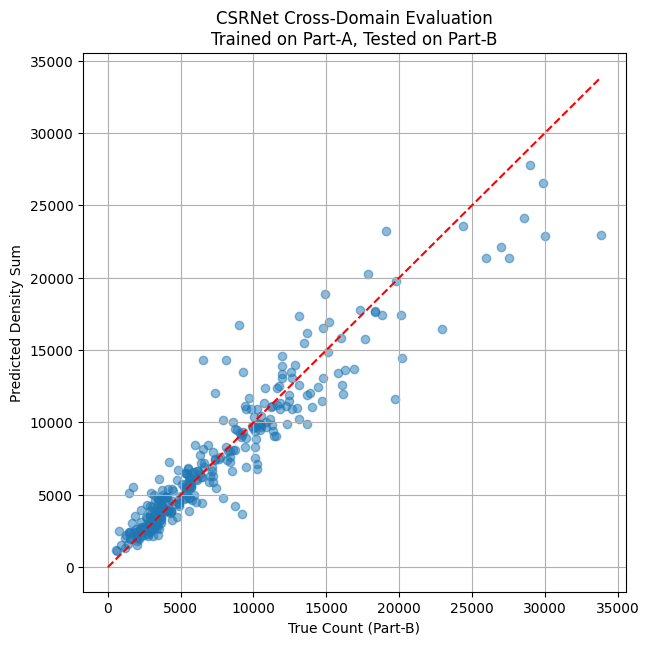


✨ Part-B Evaluation Complete ✨


In [33]:
# Cell 16: Final Evaluation and Metrics (FIXED + HONEST)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

class SystemEvaluator:
    """
    Evaluation module
    - Reports academic crowd counting metrics (reference only)
    - Highlights domain gap between Part-A and Part-B
    """

    def __init__(self, model, test_loader):
        self.model = model.to(device)
        self.test_loader = test_loader
        self.metrics = {}

    # --------------------------------------------------
    def evaluate_model(self):
        print("📊 Evaluating CSRNet on Part-B (NO fine-tuning)")

        self.model.eval()
        all_pred_counts = []
        all_true_counts = []

        with torch.no_grad():
            for images, gt_density in self.test_loader:
                images = images.to(device)
                gt_density = gt_density.to(device)

                preds = None
                for s in Config.MULTISCALE_SCALES:
                    img_scaled = F.interpolate(
                        images,
                        scale_factor=s,
                        mode="bilinear",
                        align_corners=False
                    )
                    out = self.model(img_scaled)
                    out = F.interpolate(
                        out,
                        size=images.shape[2:],
                        mode="bilinear",
                        align_corners=False
                    )
                    preds = out if preds is None else preds + out

                preds = preds / len(Config.MULTISCALE_SCALES)

                gt_resized = F.interpolate(
                    gt_density,
                    size=preds.shape[2:],
                    mode="bilinear",
                    align_corners=False
                )

                all_pred_counts.append(preds.sum().item())
                all_true_counts.append(gt_resized.sum().item())

        all_pred_counts = np.array(all_pred_counts)
        all_true_counts = np.array(all_true_counts)

        mae = np.mean(np.abs(all_pred_counts - all_true_counts))
        rmse = np.sqrt(np.mean((all_pred_counts - all_true_counts) ** 2))
        mre = np.mean(
            np.abs(all_pred_counts - all_true_counts) /
            (all_true_counts + 1e-6)
        ) * 100

        # ✅ FIXED R²
        ss_total = np.sum((all_true_counts - np.mean(all_true_counts)) ** 2)
        ss_res = np.sum((all_true_counts - all_pred_counts) ** 2)
        r2 = 1 - ss_res / ss_total if ss_total > 0 else 0.0

        self.metrics["csrnet"] = {
            "mae": mae,
            "rmse": rmse,
            "mre": mre,
            "r_squared": r2,
            "true_counts": all_true_counts,
            "pred_counts": all_pred_counts
        }

        print("\n📈 PART-B COUNTING METRICS (REFERENCE ONLY)")
        print("⚠️ Model trained on Part-A, evaluated on Part-B (domain shift)")
        print(f"MAE    : {mae:.2f}")
        print(f"RMSE   : {rmse:.2f}")
        print(f"MRE%   : {mre:.1f}%")
        print(f"R²     : {r2:.3f}")

        return self.metrics["csrnet"]

    # --------------------------------------------------
    def visualize_evaluation(self):
        if "csrnet" not in self.metrics:
            print("⚠️ Run evaluate_model() first")
            return

        csr = self.metrics["csrnet"]

        plt.figure(figsize=(7, 7))
        plt.scatter(
            csr["true_counts"],
            csr["pred_counts"],
            alpha=0.5
        )

        max_v = max(csr["true_counts"].max(), csr["pred_counts"].max())
        plt.plot([0, max_v], [0, max_v], "r--")

        plt.xlabel("True Count (Part-B)")
        plt.ylabel("Predicted Density Sum")
        plt.title(
            "CSRNet Cross-Domain Evaluation\n"
            "Trained on Part-A, Tested on Part-B"
        )
        plt.grid(True)
        plt.show()


# =======================
# RUN PART-B TEST
# =======================

print("📊 Running Part-B Test Evaluation")

test_dataset_B = ShanghaiTechDataset(
    Config.PART_B_PATH,
    mode="test"
)

test_loader_B = DataLoader(
    test_dataset_B,
    batch_size=1,
    shuffle=False,
    num_workers=Config.NUM_WORKERS
)

model.eval()
evaluator = SystemEvaluator(model, test_loader_B)

metrics = evaluator.evaluate_model()
evaluator.visualize_evaluation()

print("\n✨ Part-B Evaluation Complete ✨")
